In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from tqdm import tqdm
import dill
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import torch
from torch.distributions import MultivariateNormal
from sbi.inference import FMPE, SNPE, NPSE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform
import sbibm
from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.calibration.critical_values import train_qr_algorithm
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions
from lf2i.plot.coverage_diagnostics import coverage_probability_plot

from vsi.toy_example.utils import lowess_bootstrap_ci, GaussianMixtureWithLogProb, likelihood_ratio_ts
from vsi.temp.utils import kdeplots2D

### Settings

In [ ]:
POI_DIM = 2  # parameter of interest
PRIOR_LOC = [0, 0]
PRIOR_VAR = 2.0 # (6*np.sqrt(2.0))**2
POI_BOUNDS = {r'$\theta_1$': (-10, 10), r'$\theta_2$': (-10, 10)}
PRIOR = MultivariateNormal(
    loc=torch.Tensor(PRIOR_LOC), covariance_matrix=PRIOR_VAR*torch.eye(n=POI_DIM)
)
# PRIOR = BoxUniform(
#     low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0]-1, POI_BOUNDS[r'$\theta_2$'][0]-1)),
#     high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1]+1, POI_BOUNDS[r'$\theta_2$'][1]+1))
# )

B = 50_000  # num simulations to estimate posterior and test statistics
B_PRIME = 30_000  # num simulations to estimate critical values
B_DOUBLE_PRIME = 20_000  # num simulations to do diagnostics
EVAL_GRID_SIZE = 30_000  # num evaluation points over parameter space to construct confidence sets
CONFIDENCE_LEVEL = 0.954, 0.683  # 0.99

REFERENCE = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0]-1, POI_BOUNDS[r'$\theta_2$'][0]-1)),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1]+1, POI_BOUNDS[r'$\theta_2$'][1]+1))
)
EVAL_GRID_DISTR = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][0])),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1], POI_BOUNDS[r'$\theta_2$'][1]))
)

POSTERIOR_KWARGS = {
    # 'norm_posterior': None
}
DEVICE = 'cpu'

In [4]:
task = sbibm.get_task('gaussian_mixture')
simulator = task.get_simulator()

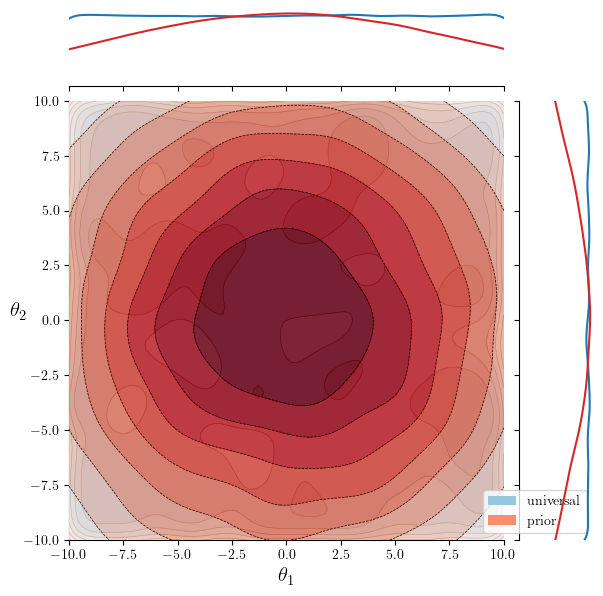

In [63]:
kdeplots2D(
    [REFERENCE.sample(sample_shape=(100_000, )), PRIOR.sample(sample_shape=(100_000, ))],
    true_theta=None,
    plot_marginals=True,
    xlim=(POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][1]), 
    ylim=(POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][1]),
    names=['universal', 'prior'],
    axis_labels=[r'$\theta_1$', r'$\theta_2$']
)

### NDE

In [73]:
with open('./results/sbibm_example/fmpe_strong_prior.pkl', 'rb') as f:
    fmpe_posterior = dill.load(f)

In [64]:
b_params = PRIOR.sample(sample_shape=(B, ))
b_samples = simulator(b_params)
b_params.shape, b_samples.shape

(torch.Size([50000, 2]), torch.Size([50000, 2]))

In [65]:
fmpe = FMPE(
    prior=PRIOR,
    device='cpu'
)

_ = fmpe.append_simulations(b_params, b_samples).train()
fmpe_posterior = fmpe.build_posterior()

 Training neural network. Epochs trained: 501

In [8]:
with open('./results/sbibm_example/fmpe_strong_prior.pkl', 'wb') as f:
    dill.dump(fmpe_posterior, f)

In [ ]:
obs_theta = torch.Tensor([0, 0])
obs_x = simulator(obs_theta)

kdeplots2D(
    [PRIOR.sample(sample_shape=(50_000, )), fmpe_posterior.sample(sample_shape=(50_000, ), x=obs_x)],
    true_theta=obs_theta.unsqueeze(0),
    ignore_lower_than=1e-10, # set to None to see potential fat tails 
    xlim=(POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][1]), 
    ylim=(POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][1]),
    names=['Prior', 'Flow Matching'],
    axis_labels=[r'$\theta_1$', r'$\theta_2$']
)

### VSI

In [53]:
b_prime_params = REFERENCE.sample(sample_shape=(B_PRIME, ))
b_prime_samples = simulator(b_prime_params)
b_prime_params.shape, b_prime_samples.shape

(torch.Size([30000, 2]), torch.Size([30000, 2]))

In [7]:
true_theta = torch.Tensor([[8.5, -8.5], [-8.5, 8.5], [-8.5, 8.5], [-8.5, -8.5], [8.5, 8.5], [0, 0], [0, 0], [0, 0]])
obs_x = simulator(true_theta)

In [89]:
with open('obs_x_theta.pkl', 'wb') as f:
    dill.dump({
        'true_theta': true_theta,
        'obs_x': obs_x
    }, f)

In [66]:
lf2i = LF2I(test_statistic=Posterior(poi_dim=2, estimator=fmpe_posterior, **POSTERIOR_KWARGS))

In [ ]:
confidence_sets = lf2i.inference(
    x=obs_x,
    evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
    confidence_level=CONFIDENCE_LEVEL,
    calibration_method='critical-values',
    calibration_model='cat-gb',
    calibration_model_kwargs={
        'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
        'n_iter': 25
    },
    T_prime=(b_prime_params, b_prime_samples),
    retrain_calibration=False
)


Constructing confidence regions ...


Evaluating posterior for 8 points ...:   0%|          | 0/8 [00:00<?, ?it/s]WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Evaluating posterior for 8 points ...: 100%|██████████| 8/8 [00:53<00:00,  6.66s/it]


In [13]:
with open('./results/sbibm_example/lf2i_strong_prior.pkl', 'wb') as f:
    dill.dump(lf2i, f)

In [74]:
with open('./results/sbibm_example/lf2i_strong_prior.pkl', 'rb') as f:
    lf2i = dill.load(f)

In [75]:
remaining = len(obs_x)
credible_sets = []
for x in obs_x:  # torch.vstack([task.get_observation(i) for i in range(1, 11)])
    print(f'Remaining: {remaining}', flush=True)
    credible_sets_x = []
    for cl in CONFIDENCE_LEVEL:
        actual_cred_level, credible_set = hpd_region(
            posterior=fmpe_posterior,
            param_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
            x=x.reshape(-1, ),
            credible_level=cl,
            num_level_sets=10_000,
            **POSTERIOR_KWARGS
        )
        #print(actual_cred_level, flush=True)
        credible_sets_x.append(credible_set)
    credible_sets.append(credible_sets_x)
    remaining -= 1

Remaining: 8
Remaining: 7
Remaining: 6
Remaining: 5
Remaining: 4
Remaining: 3
Remaining: 2
Remaining: 1


In [ ]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

for idx_obs in range(8):

    if idx_obs <= 4:
        title = r'\textbf{a)} Prior poorly aligned with $\theta^{\star}$'
    else:
        title = r'\textbf{b)} Prior well aligned with $\theta^{\star}$'

    plot_parameter_regions(
        *credible_sets[idx_obs], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
        param_dim=2,
        true_parameter=true_theta[idx_obs, :],
        prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
        parameter_space_bounds={
            r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
            r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
        },
        colors=[
            'purple', 'deeppink', # 'hotpink',  # credible sets
            #'teal', 'mediumseagreen', 'darkseagreen', # confidence sets
        ],
        region_names=[
            *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
            #*[f'CS {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
        ],
        labels=[r'$\theta_1$', r'$\theta_2$'],
        linestyles=['-', '--'],  # , ':'
        param_names=[r'$\theta_1$', r'$\theta_2$'],
        alpha_shape=True,
        alpha=3,
        scatter=False,
        figsize=(5, 5),
        # save_fig_path=f'./results/sbibm_example/hpd{idx_obs}.pdf',
        remove_legend=True,
        title=title,
        custom_ax=None
    )

In [ ]:
for idx_obs in range(8):

    plot_parameter_regions(
        *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
        param_dim=2,
        true_parameter=true_theta[idx_obs, :],
        prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
        parameter_space_bounds={
            r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
            r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
        },
        colors=[
            #'purple', 'deeppink', 'hotpink',  # credible sets
            'teal', 'mediumseagreen', # 'darkseagreen', # confidence sets
        ],
        region_names=[
            #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
            *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
        ],
        labels=[r'$\theta_1$', r'$\theta_2$'],
        linestyles=['-', '--'],  # , ':'
        param_names=[r'$\theta_1$', r'$\theta_2$'],
        alpha_shape=True,
        alpha=3,
        scatter=False,
        figsize=(5, 5),
        # save_fig_path=f'./results/sbibm_example/freb{idx_obs}.pdf',
        remove_legend=True,
        title=None,
        custom_ax=None
    )

### COVERAGE DIAGNOSTICS

In [58]:
b_double_prime_params = REFERENCE.sample(sample_shape=(B_DOUBLE_PRIME, ))
b_double_prime_samples = simulator(b_double_prime_params)
b_double_prime_params.shape, b_double_prime_samples.shape

(torch.Size([20000, 2]), torch.Size([20000, 2]))

In [69]:
diagn_objects = {}
for cl in CONFIDENCE_LEVEL[:1]:  # 0.954
    print(cl, flush=True)
    diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset = lf2i.diagnostics(
        region_type='lf2i',
        confidence_level=cl,
        calibration_method='critical-values',
        coverage_estimator='splines',
        T_double_prime=(b_double_prime_params, b_double_prime_samples),
    )
    diagn_objects[cl] = (diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset)

0.954


Evaluating posterior for 20000 points ...: 100%|██████████| 20000/20000 [01:39<00:00, 201.66it/s]


In [17]:
with open('./results/sbibm_example/diagn_confset_strong_prior.pkl', 'wb') as f:
    dill.dump(diagn_objects, f)

In [76]:
with open('./results/sbibm_example/diagn_confset_strong_prior.pkl', 'rb') as f:
    diagn_objects = dill.load(f)

In [70]:
diagn_objects_cred = {}
size_grid_for_sizes = 5_000
for cl in CONFIDENCE_LEVEL[:1]:  # 0.954
    print(cl, flush=True)
    diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible, sizes = lf2i.diagnostics(
        region_type='posterior',
        confidence_level=cl,
        coverage_estimator='splines',
        T_double_prime=(b_double_prime_params, b_double_prime_samples),
        posterior_estimator=lf2i.test_statistic.estimator,
        evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(size_grid_for_sizes, )),
        num_level_sets=5_000,
        **POSTERIOR_KWARGS
    )
    diagn_objects_cred[cl] = (diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible, sizes)

0.954


Computing indicators for 20000 credible regions: 100%|██████████| 20000/20000 [3:57:47<00:00,  1.40it/s]  


In [19]:
with open('./results/sbibm_example/diagn_cred_strong_prior.pkl', 'wb') as f:
    dill.dump(diagn_objects_cred, f)

In [77]:
with open('./results/sbibm_example/diagn_cred_strong_prior.pkl', 'rb') as f:
    diagn_objects_cred = dill.load(f)

### SIZE

#### LRT baseline

In [326]:
task_with_log_prob = GaussianMixtureWithLogProb()

In [331]:
b_prime_lrt = np.array([
    likelihood_ratio_ts(mu=b_prime_params[idx, :].numpy(), x=b_prime_samples[idx, :].numpy(), task=task_with_log_prob, poi_bounds=POI_BOUNDS[r'$\mu_1$']) for idx in tqdm(range(B_PRIME))
])

100%|██████████| 10000/10000 [00:45<00:00, 221.88it/s]


In [338]:
qr = train_qr_algorithm(
    test_statistics=b_prime_lrt.reshape(-1, ),
    parameters=b_prime_params.numpy(),
    alpha=list(CONFIDENCE_LEVEL),
    param_dim=2, 
    algorithm='cat-gb',
    algorithm_kwargs={
        'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 10]},
        'n_iter': 25
    }
)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [352]:
size_grid_for_sizes = 5_000
grid = EVAL_GRID_DISTR.sample(sample_shape=(size_grid_for_sizes, )).numpy()
b_double_prime_lrt = np.vstack([
    likelihood_ratio_ts(mu=grid, x=b_double_prime_samples[idx, :].numpy(), task=task_with_log_prob, poi_bounds=POI_BOUNDS[r'$\mu_1$']).reshape(1, size_grid_for_sizes) for idx in range(B_DOUBLE_PRIME)
])

In [ ]:
which_retained = b_double_prime_lrt <= qr.predict(grid)[:, 0].reshape(1, size_grid_for_sizes)  # [0] because we only analyze 95% level for sizes
lrt_confsets = [grid[which_retained[idx, :], :] for idx in range(B_DOUBLE_PRIME)]
lrt_confsets_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in lrt_confsets])

#### FreB

In [24]:
size_grid_for_sizes = 5_000
confidence_sets_for_size = lf2i.inference(
    x=b_double_prime_samples,
    evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(size_grid_for_sizes, )),
    confidence_level=CONFIDENCE_LEVEL,
    calibration_method='critical-values',
)


Constructing confidence regions ...


Evaluating posterior for 20000 points ...: 100%|██████████| 20000/20000 [3:28:14<00:00,  1.60it/s]  


In [ ]:
with open('./results/sbibm_example/confidence_sets_for_size.pkl', 'wb') as f:
    dill.dump(confidence_sets_for_size, f)

In [ ]:
with open('./results/sbibm_example/confidence_sets_for_size.pkl', 'rb') as f:
    confidence_sets_for_size = dill.load(f)

In [27]:
size_grid_for_sizes = 5_000
confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])

#### COMPARISON

In [28]:
distance_from_prior_mean = np.linalg.norm(diagn_objects_cred[CONFIDENCE_LEVEL[0]][1], axis=1)

hpd_x_lowess, hpd_y_lowess, hpd_lowess_lower_bound, hpd_lowess_upper_bound = lowess_bootstrap_ci(
    x=distance_from_prior_mean, y=diagn_objects_cred[CONFIDENCE_LEVEL[0]][-1], n_boot=1000, lowess_frac=0.2, ci=np.array([68.3, 95.4, 99.7])
)
freb_x_lowess, freb_y_lowess, freb_lowess_lower_bound, freb_lowess_upper_bound = lowess_bootstrap_ci(
    x=distance_from_prior_mean, y=confset_sizes, n_boot=1000, lowess_frac=0.2, ci=np.array([68.3, 95.4, 99.7])
)
# lrt_x_lowess, lrt_y_lowess, lrt_lowess_lower_bound, lrt_lowess_upper_bound = lowess_bootstrap_ci(
#     x=distance_from_prior_mean, y=lrt_confsets_sizes, n_boot=1000, lowess_frac=0.2, ci=np.array([68.3, 95.4, 99.7])
# )

Bootstrapping: 100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


In [ ]:
which_ci = 2  # 99.7% bootstrap intervals

def plot1(axis):
    if axis is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        ax = axis

    #### HPD
    #sns.scatterplot(x=distance_from_prior_mean/np.sqrt(PRIOR_VAR), y=diagn_objects_cred[CONFIDENCE_LEVEL[0]][-1], color="purple", alpha=0.5, ax=ax, marker='x', label='HPD')
    ax.plot(hpd_x_lowess/np.sqrt(100), hpd_y_lowess, color="purple", label="HPD", linewidth=4.5, linestyle=':')
    ax.fill_between(hpd_x_lowess/np.sqrt(100), hpd_lowess_lower_bound[which_ci, :], hpd_lowess_upper_bound[which_ci, :], color="purple", alpha=0.3)

    #### FreB
    #sns.scatterplot(x=distance_from_prior_mean/np.sqrt(PRIOR_VAR), y=confset_sizes, alpha=0.5, ax=ax, marker='o', edgecolor="teal", facecolor='white', label='HPD')
    ax.plot(freb_x_lowess/np.sqrt(100), freb_y_lowess, color="teal", label="FreB", linewidth=4.5, linestyle=':')
    ax.fill_between(freb_x_lowess/np.sqrt(100), freb_lowess_lower_bound[which_ci, :], freb_lowess_upper_bound[which_ci, :], color="teal", alpha=0.3)

    # #### LRT
    # #sns.scatterplot(x=distance_from_prior_mean/np.sqrt(PRIOR_VAR), y=lrt_confsets_sizes, alpha=0.5, ax=ax, marker='o', edgecolor="steelblue", facecolor='white', label='Oracle LRT')
    # ax.plot(lrt_x_lowess/np.sqrt(PRIOR_VAR), lrt_y_lowess, color="steelblue", label="Oracle LRT", linewidth=2)
    # ax.fill_between(lrt_x_lowess/np.sqrt(PRIOR_VAR), lrt_lowess_lower_bound[which_ci, :], lrt_lowess_upper_bound[which_ci, :], color="steelblue", alpha=0.3)

    ax.set_xlabel(r'Distance from prior mean [units of $\sigma_{\text{prior}}$]', size=35)  # - \mathbb{E}_\pi(\mu)
    ax.set_ylabel(r'Avg. Size [\% of $\text{Vol}(\Theta)$]', size=35)
    ax.tick_params(labelsize=30)
    ax.legend(prop={'size': 25})
    ax.set_title(r'\textbf{E)} Average Constraining Power', size=45, pad=28)
    # plt.savefig(f'./results/sbibm_example/power{CONFIDENCE_LEVEL[0]}.pdf', bbox_inches='tight')
    if axis is None:
        plt.show()

In [69]:
distance_from_prior_mean = np.linalg.norm(diagn_objects_cred[CONFIDENCE_LEVEL[0]][1], axis=1)

hpd_x_lowess_cov, hpd_y_lowess_cov, hpd_lowess_lower_bound_cov, hpd_lowess_upper_bound_cov = lowess_bootstrap_ci(
    x=distance_from_prior_mean, y=diagn_objects_cred[CONFIDENCE_LEVEL[0]][2], n_boot=1000, lowess_frac=0.2, ci=np.array([68.3, 95.4, 99.7])
)
freb_x_lowess_cov, freb_y_lowess_cov, freb_lowess_lower_bound_cov, freb_lowess_upper_bound_cov = lowess_bootstrap_ci(
    x=distance_from_prior_mean, y=diagn_objects[CONFIDENCE_LEVEL[0]][2], n_boot=1000, lowess_frac=0.2, ci=np.array([68.3, 95.4, 99.7])
)

Bootstrapping: 100%|██████████| 1000/1000 [04:14<00:00,  3.93it/s]


In [14]:
which_ci = 2  # 99.7% bootstrap intervals

def plot2(axis):
    if axis is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        ax = axis

    #### HPD
    #sns.scatterplot(x=distance_from_prior_mean/np.sqrt(PRIOR_VAR), y=diagn_objects_cred[CONFIDENCE_LEVEL[0]][-1], color="purple", alpha=0.5, ax=ax, marker='x', label='HPD')
    ax.plot(hpd_x_lowess_cov/np.sqrt(PRIOR_VAR), hpd_y_lowess_cov*100, color="purple", label="HPD", linewidth=4.5, zorder=999)
    ax.fill_between(hpd_x_lowess_cov/np.sqrt(PRIOR_VAR), hpd_lowess_lower_bound_cov[which_ci, :]*100, hpd_lowess_upper_bound_cov[which_ci, :]*100, color="purple", alpha=0.3)

    #### FreB
    #sns.scatterplot(x=distance_from_prior_mean/np.sqrt(PRIOR_VAR), y=confset_sizes, alpha=0.5, ax=ax, marker='o', edgecolor="mediumseagreen", facecolor='white', label='HPD')
    ax.plot(freb_x_lowess_cov/np.sqrt(PRIOR_VAR), freb_y_lowess_cov*100, color="teal", label="FreB", linewidth=4.5, zorder=1000)
    ax.fill_between(freb_x_lowess_cov/np.sqrt(PRIOR_VAR), freb_lowess_lower_bound_cov[which_ci, :]*100, freb_lowess_upper_bound_cov[which_ci, :]*100, color="teal", alpha=0.3)

    # #### LRT
    # #sns.scatterplot(x=distance_from_prior_mean/np.sqrt(PRIOR_VAR), y=lrt_confsets_sizes, alpha=0.5, ax=ax, marker='o', edgecolor="steelblue", facecolor='white', label='Oracle LRT')
    # ax.plot(lrt_x_lowess/np.sqrt(PRIOR_VAR), lrt_y_lowess, color="steelblue", label="Oracle LRT", linewidth=2)
    # ax.fill_between(lrt_x_lowess/np.sqrt(PRIOR_VAR), lrt_lowess_lower_bound[which_ci, :], lrt_lowess_upper_bound[which_ci, :], color="steelblue", alpha=0.3)

    ax.axhline(y=CONFIDENCE_LEVEL[0]*100, color='black', linestyle='--', linewidth=2, zorder=1001, label=f"Nominal level")
    ax.text(
        0.01, CONFIDENCE_LEVEL[0]*100-6, s=f'{CONFIDENCE_LEVEL[0]*100:.0f}\%', 
        transform=ax.get_yaxis_transform(), horizontalalignment='left', verticalalignment='center', zorder=50, fontdict={'size': 20}
    )

    ax.set_xlabel(r'Distance from prior mean [units of $\sigma_{\text{prior}}$]', size=35)  # - \mathbb{E}_\pi(\mu)
    ax.set_ylabel(r'Avg. Coverage [\%]', size=35)
    ax.tick_params(labelsize=30)
    ax.legend(prop={'size': 25})
    ax.set_title(r'\textbf{E)} Average Coverage', size=45, pad=28)
    ax.set_ylim(0, 105)
    # plt.savefig(f'./results/sbibm_example/coverage{CONFIDENCE_LEVEL[0]}.pdf', bbox_inches='tight')
    if axis is None:
        plt.show()

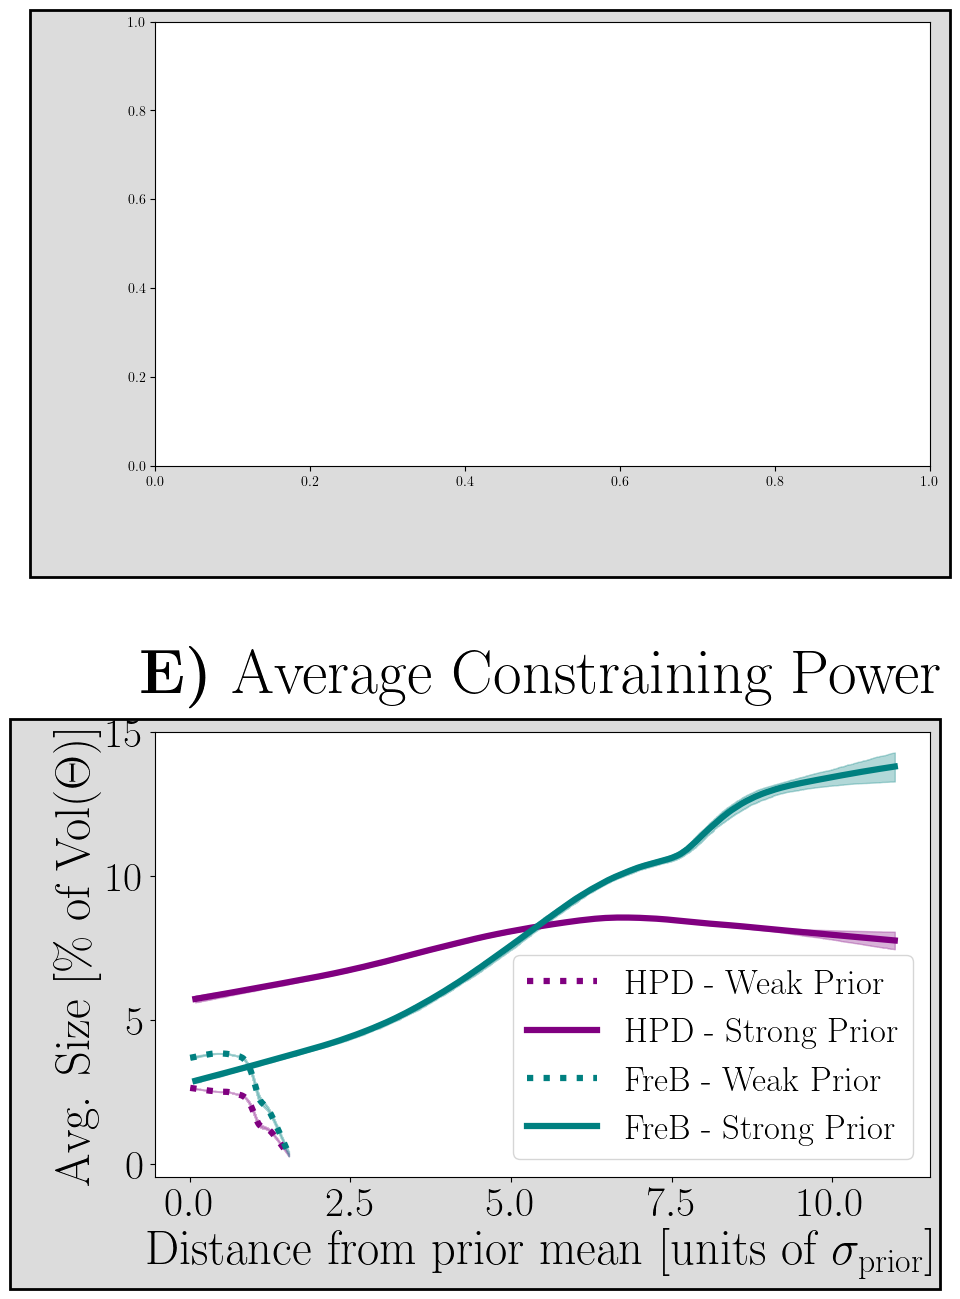

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15))

### coverage
# plot2(ax[0])

### power
plot1(ax[1])

fig.patches.append(patches.Rectangle((0.0, 0.51), 0.92, 0.378, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))
fig.patches.append(patches.Rectangle((-0.02, 0.035), 0.93, 0.38, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))
plt.subplots_adjust(hspace=0.6)

# plt.savefig(f'./results/sbibm_example/avg_cov_and_pow{CONFIDENCE_LEVEL[0]}.pdf', bbox_inches='tight')
plt.show()

### Final plots

/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:200: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:200: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:200: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose 

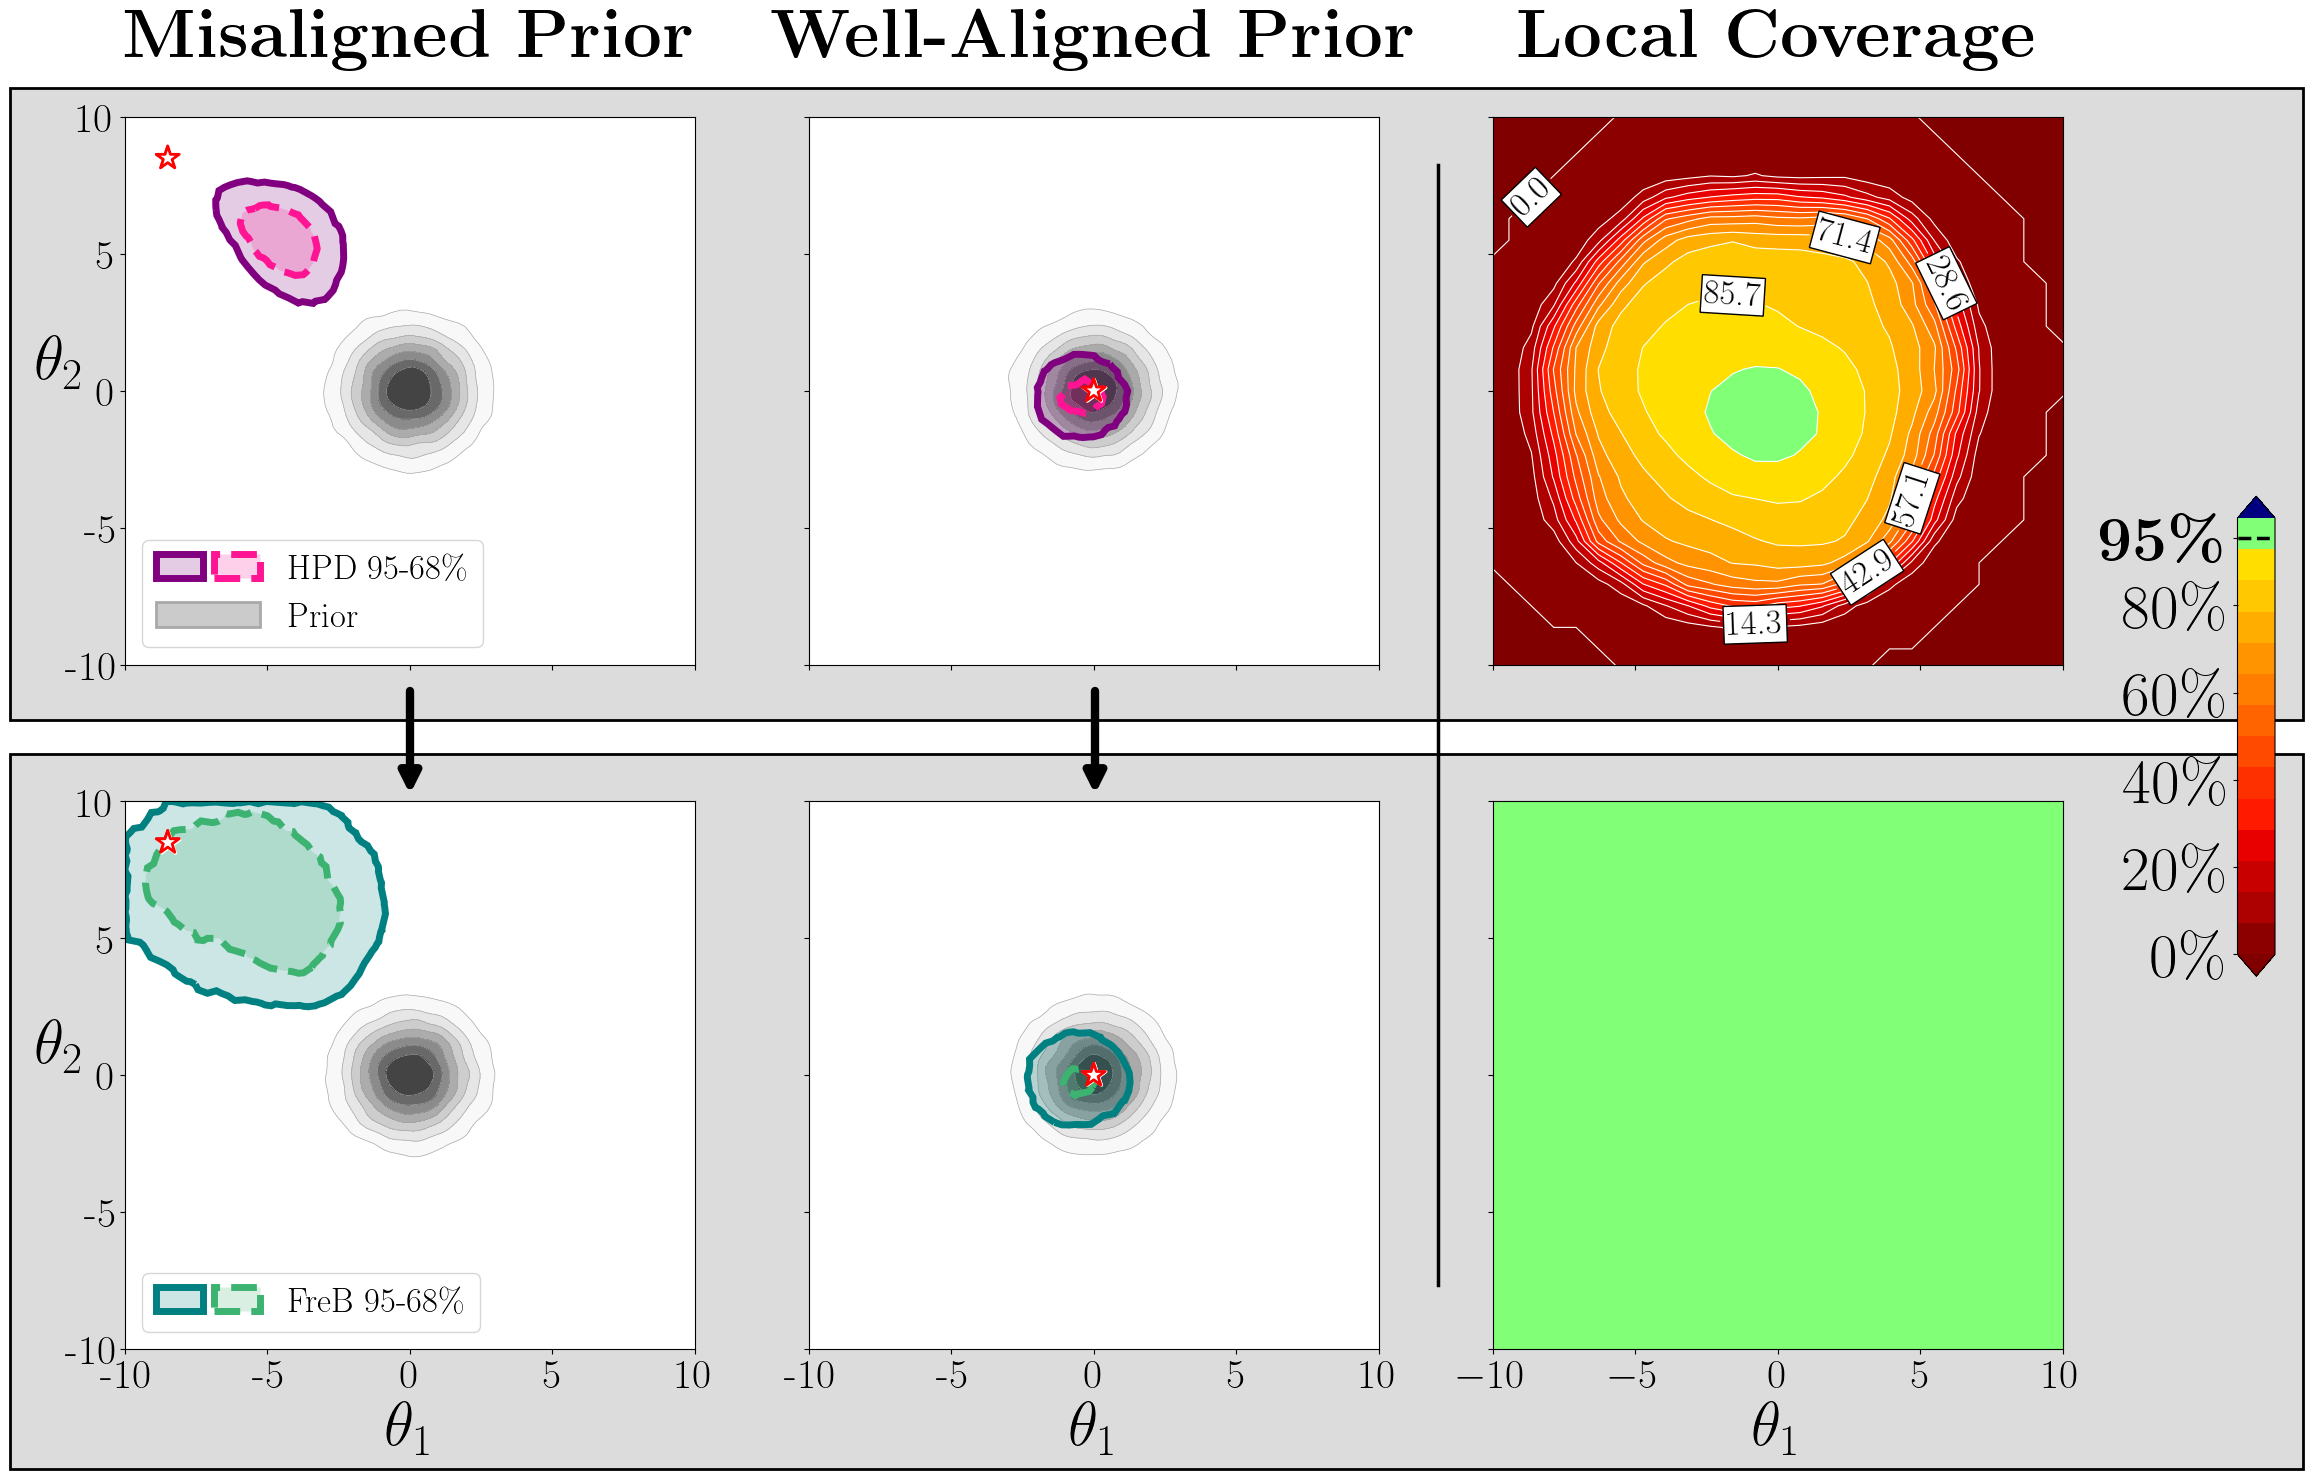

In [ ]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

fig, ax = plt.subplots(2, 3, figsize=(25, 16))
fig.subplots_adjust(hspace=0.25)

plot_parameter_regions(
    *credible_sets[1],
    param_dim=2,
    true_parameter=true_theta[1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink', #'hotpink',  # credible sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=False,
    custom_ax=ax[0][0]
)
ax[0][0].set_xticklabels([])
ax[0][0].set_xlabel('')
ax[0][0].set_ylabel(r'$\theta_2$', fontsize=45)
ax[0][0].tick_params(labelsize=30)
ax[0][0].set_title(r'\textbf{Misaligned Prior}', size=50, pad=43)

plot_parameter_regions(
    *[confidence_sets[j][1] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen', #'darkseagreen', # confidence sets
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=False,
    custom_ax=ax[1][0]
)
ax[1][0].tick_params(labelsize=30)
ax[1][0].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][0].set_ylabel(r'$\theta_2$', fontsize=45)


plot_parameter_regions(
    *credible_sets[-1], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[-1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink', #'hotpink',  # credible sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=True,
    custom_ax=ax[0][1]
)
ax[0][1].set_xticklabels([])
ax[0][1].set_yticklabels([])
ax[0][1].set_xlabel('')
ax[0][1].set_ylabel('', fontsize=45)
ax[0][1].tick_params(labelsize=30)
ax[0][1].set_title(r'\textbf{Well-Aligned Prior}', size=50, pad=43)

plot_parameter_regions(
    *[confidence_sets[j][-1] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[-1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen', #'darkseagreen', # confidence sets
    ],
    region_names=[
        #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=True,
    custom_ax=ax[1][1]
)
ax[1][1].tick_params(labelsize=30)
ax[1][1].set_yticklabels([])
ax[1][1].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][1].set_ylabel('', fontsize=45)


hpd_diagn_plot = coverage_probability_plot(
    parameters=diagn_objects_cred[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects_cred[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    xlims=(-10, 10),
    ylims=(-10, 10),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    #figsize=(9, 7),
    title=None,
    show_text=False,
    custom_ax=ax[0][2],
)
ax[0][2].set_xlim(-10, 10)
ax[0][2].set_ylim(-10, 10)
ax[0][2].set_xticks(np.linspace(-10, 10, 5).astype(int))
ax[0][2].set_yticks(np.linspace(-10, 10, 5).astype(int))
ax[0][2].set_xticklabels([])
ax[0][2].set_yticklabels([])
ax[0][2].set_xlabel('')
ax[0][2].set_ylabel('', fontsize=45, rotation=0)
ax[0][2].tick_params(labelsize=30)
ax[0][2].set_title(r'\textbf{Local Coverage}', size=50, pad=43)


_ = coverage_probability_plot(
    parameters=diagn_objects[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    xlims=(-10, 10),
    ylims=(-10, 10),
    #figsize=(9, 7),
    title=None,
    show_text=False,
    custom_ax=ax[1][2],
)
ax[1][2].set_xlim(-10, 10)
ax[1][2].set_ylim(-10, 10)
ax[1][2].set_xticks(np.linspace(-10, 10, 5).astype(int))
ax[1][2].set_yticks(np.linspace(-10, 10, 5).astype(int))
ax[1][2].tick_params(labelsize=30)
ax[1][2].set_yticklabels([])
ax[1][2].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][2].set_ylabel('', rotation=0, fontsize=45)

cax = fig.add_axes([0.97, 0.343, 0.015, 0.3])  # Adjust these values to move the colorbar
cbar = fig.colorbar(hpd_diagn_plot, format='%1.2f', cax=cax)
standard_ticks = np.round(np.linspace(0, 100, num=6), 1)
all_ticks = np.unique(np.sort(np.append(standard_ticks[:-1], CONFIDENCE_LEVEL[0] * 100)))
tick_labels = [f"{label:.0f}\%" for label in all_ticks]
for i, label in enumerate(all_ticks):
    if abs(label - CONFIDENCE_LEVEL[0]*100) <= 1e-6:
        tick_labels[i] = r"$\mathbf{{{label}}}$\textbf{{\%}}".format(label=int(label))
cbar.ax.yaxis.set_ticks(all_ticks)
cbar.ax.set_yticklabels(tick_labels, fontsize=45)
cbar.ax.axhline(y=CONFIDENCE_LEVEL[0]*100, xmin=0, xmax=1, color="black", linestyle="--", linewidth=2.5)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')


fig.patches.append(patches.Rectangle((0.079, 0.503), 0.917, 0.395, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))
fig.patches.append(patches.Rectangle((0.079, 0.035), 0.917, 0.447, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))

line = mlines.Line2D(
    [0.65, 0.65],   # x-coords (start, end)
    [0.15, 0.85],               # y-coords (start, end)
    transform=fig.transFigure,
    ls='-',                  # dashed
    lw=2.5,
    color='black',
    clip_on=False
)

fig.add_artist(line)

fig.add_artist(FancyArrowPatch(
    posA=(0.239, 0.523), posB=(0.239, 0.455),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
    color='black', linewidth=6, zorder=10
))
fig.add_artist(FancyArrowPatch(
    posA=(0.513, 0.523), posB=(0.513, 0.455),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
    color='black', linewidth=6, zorder=10
))
# fig.add_artist(FancyArrowPatch(
#     posA=(0.787, 0.523), posB=(0.787, 0.455),
#     connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
#     color='black', linewidth=6, zorder=10
# ))

plt.savefig('./results/sbibm_example/example0_horizontal.pdf', bbox_inches='tight')
plt.show()

/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:200: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:200: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:200: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose 

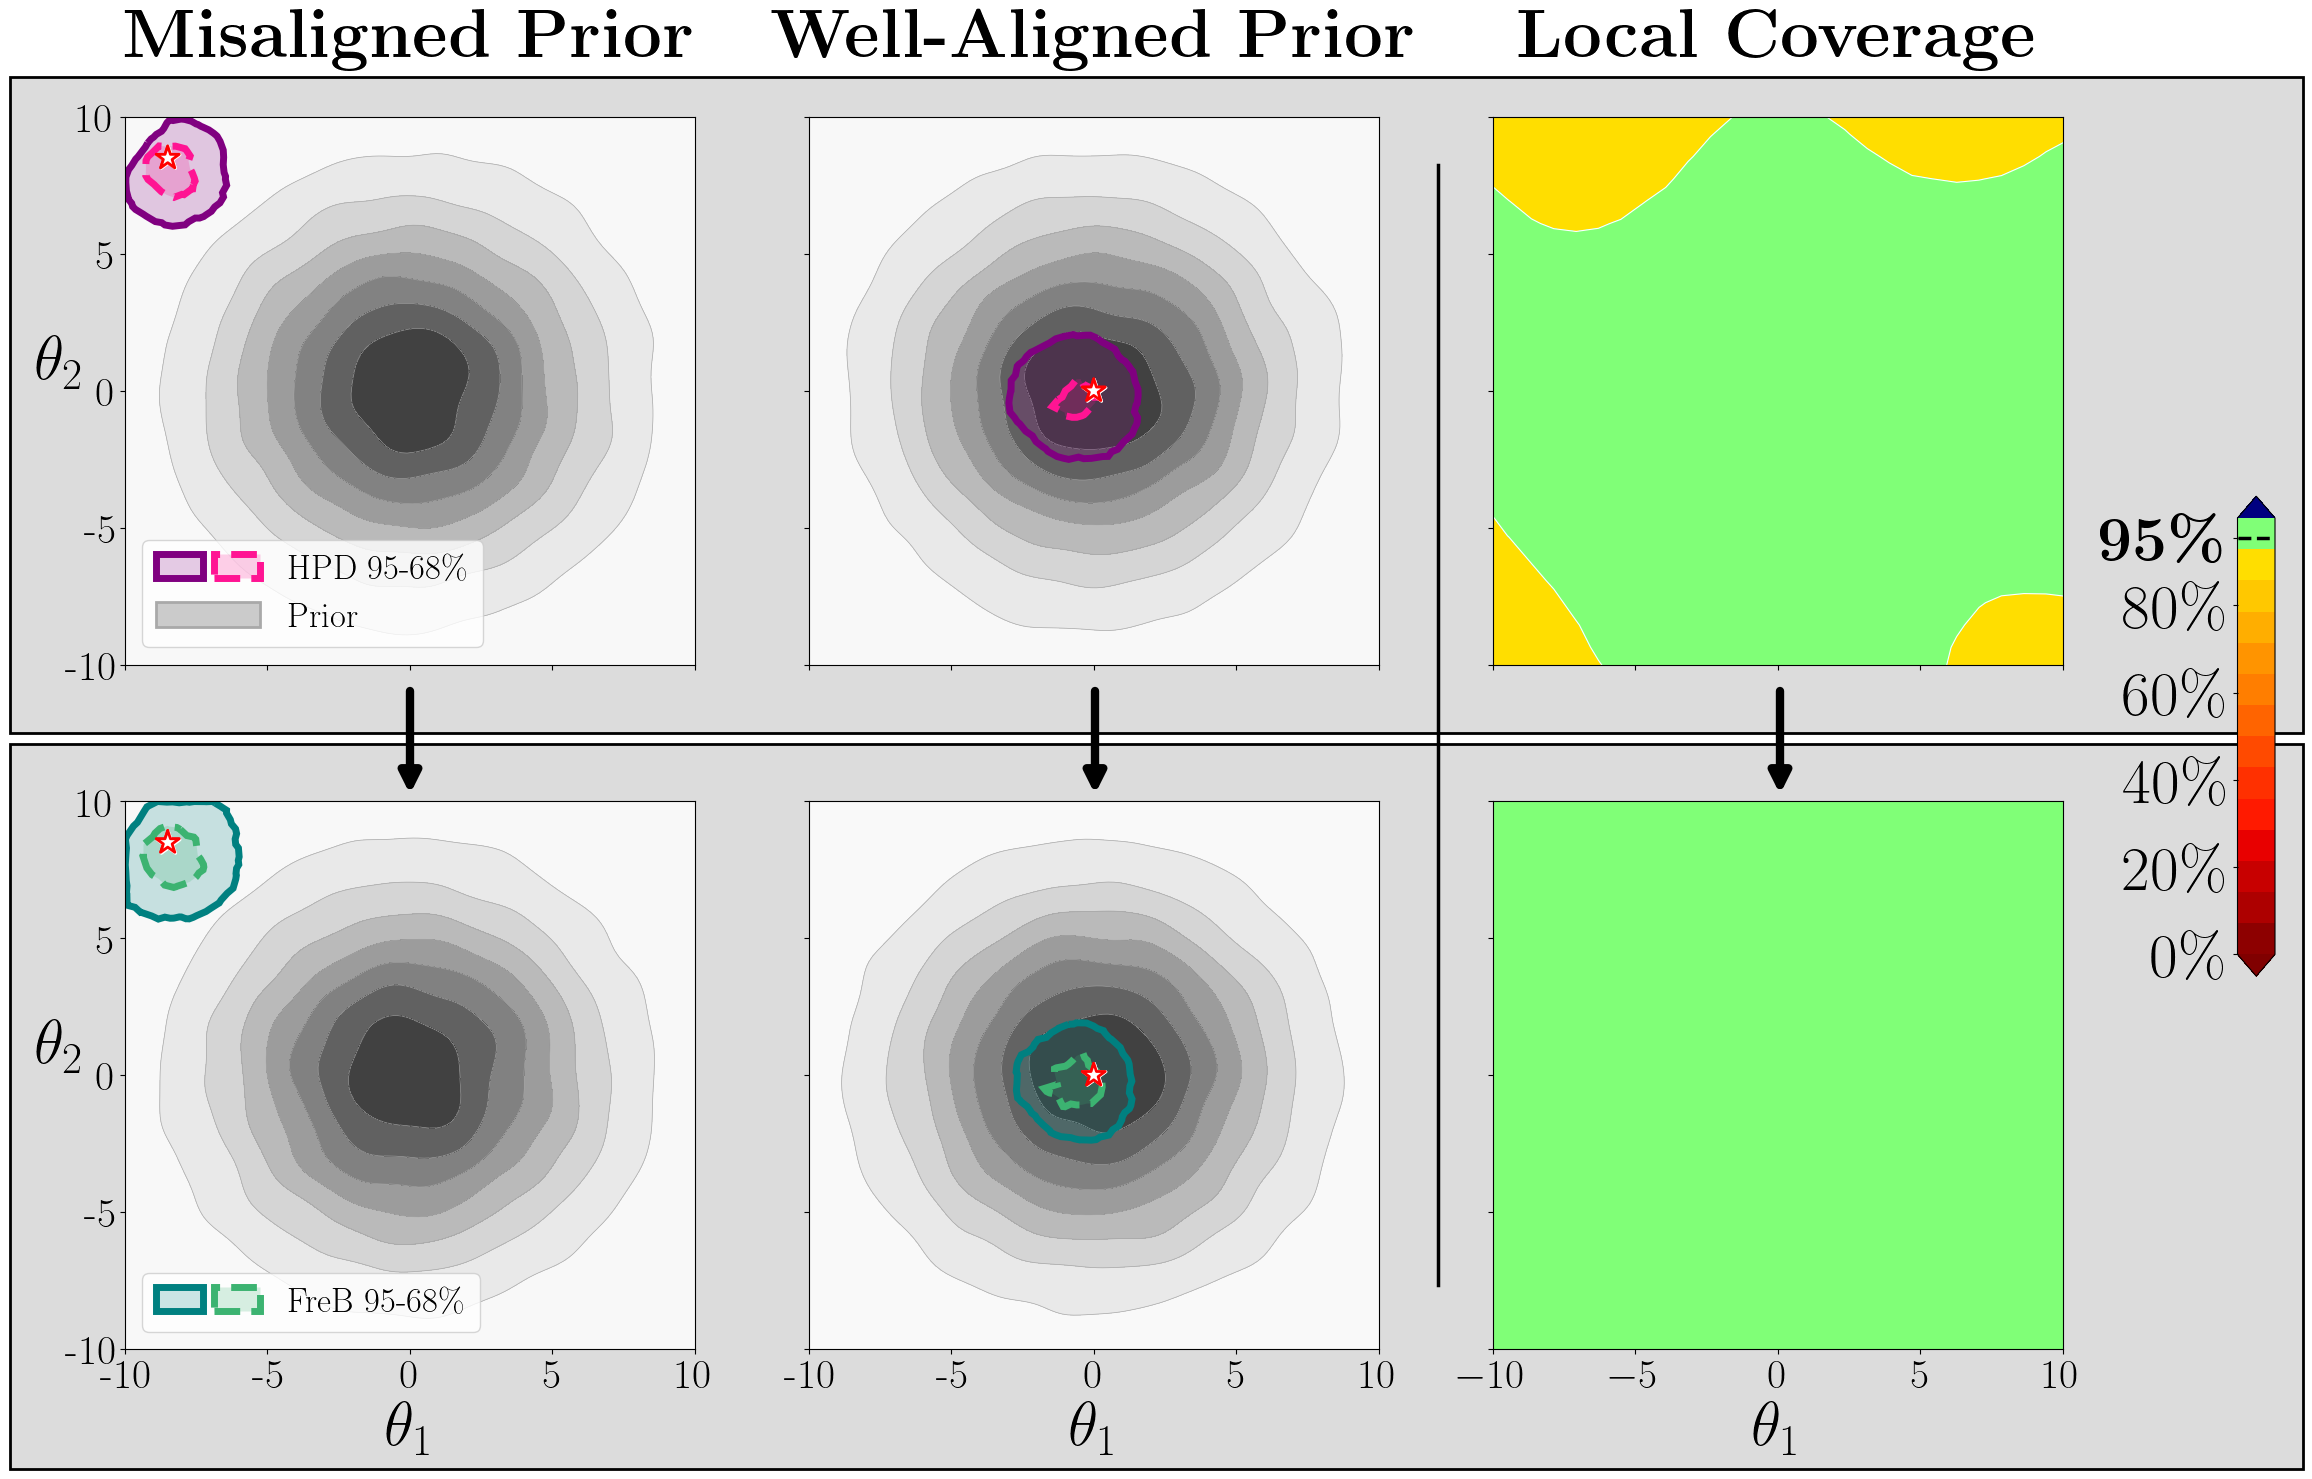

In [61]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

fig, ax = plt.subplots(2, 3, figsize=(25, 16))
fig.subplots_adjust(hspace=0.25)

plot_parameter_regions(
    *credible_sets[1],
    param_dim=2,
    true_parameter=true_theta[1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink', #'hotpink',  # credible sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=False,
    custom_ax=ax[0][0]
)
ax[0][0].set_xticklabels([])
ax[0][0].set_xlabel('')
ax[0][0].set_ylabel(r'$\theta_2$', fontsize=45)
ax[0][0].tick_params(labelsize=30)
ax[0][0].set_title(r'\textbf{Misaligned Prior}', size=50, pad=43)

plot_parameter_regions(
    *[confidence_sets[j][1] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen', #'darkseagreen', # confidence sets
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=False,
    custom_ax=ax[1][0]
)
ax[1][0].tick_params(labelsize=30)
ax[1][0].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][0].set_ylabel(r'$\theta_2$', fontsize=45)


plot_parameter_regions(
    *credible_sets[-1], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[-1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink', #'hotpink',  # credible sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=True,
    custom_ax=ax[0][1]
)
ax[0][1].set_xticklabels([])
ax[0][1].set_yticklabels([])
ax[0][1].set_xlabel('')
ax[0][1].set_ylabel('', fontsize=45)
ax[0][1].tick_params(labelsize=30)
ax[0][1].set_title(r'\textbf{Well-Aligned Prior}', size=50, pad=43)

plot_parameter_regions(
    *[confidence_sets[j][-1] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[-1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen', #'darkseagreen', # confidence sets
    ],
    region_names=[
        #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=True,
    custom_ax=ax[1][1]
)
ax[1][1].tick_params(labelsize=30)
ax[1][1].set_yticklabels([])
ax[1][1].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][1].set_ylabel('', fontsize=45)


hpd_diagn_plot = coverage_probability_plot(
    parameters=diagn_objects_cred[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects_cred[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    xlims=(-10, 10),
    ylims=(-10, 10),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    #figsize=(9, 7),
    title=None,
    show_text=False,
    custom_ax=ax[0][2],
)
ax[0][2].set_xlim(-10, 10)
ax[0][2].set_ylim(-10, 10)
ax[0][2].set_xticks(np.linspace(-10, 10, 5).astype(int))
ax[0][2].set_yticks(np.linspace(-10, 10, 5).astype(int))
ax[0][2].set_xticklabels([])
ax[0][2].set_yticklabels([])
ax[0][2].set_xlabel('')
ax[0][2].set_ylabel('', fontsize=45, rotation=0)
ax[0][2].tick_params(labelsize=30)
ax[0][2].set_title(r'\textbf{Local Coverage}', size=50, pad=43)


_ = coverage_probability_plot(
    parameters=diagn_objects[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    xlims=(-10, 10),
    ylims=(-10, 10),
    #figsize=(9, 7),
    title=None,
    show_text=False,
    custom_ax=ax[1][2],
)
ax[1][2].set_xlim(-10, 10)
ax[1][2].set_ylim(-10, 10)
ax[1][2].set_xticks(np.linspace(-10, 10, 5).astype(int))
ax[1][2].set_yticks(np.linspace(-10, 10, 5).astype(int))
ax[1][2].tick_params(labelsize=30)
ax[1][2].set_yticklabels([])
ax[1][2].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][2].set_ylabel('', rotation=0, fontsize=45)

cax = fig.add_axes([0.97, 0.343, 0.015, 0.3])  # Adjust these values to move the colorbar
cbar = fig.colorbar(hpd_diagn_plot, format='%1.2f', cax=cax)
standard_ticks = np.round(np.linspace(0, 100, num=6), 1)
all_ticks = np.unique(np.sort(np.append(standard_ticks[:-1], CONFIDENCE_LEVEL[0] * 100))) # all_ticks = standard_ticks # 
tick_labels = [f"{label:.0f}\%" for label in all_ticks]
for i, label in enumerate(all_ticks):
    if abs(label - CONFIDENCE_LEVEL[0]*100) <= 1e-6:
        tick_labels[i] = r"$\mathbf{{{label}}}$\textbf{{\%}}".format(label=int(label))
cbar.ax.yaxis.set_ticks(all_ticks)
cbar.ax.set_yticklabels(tick_labels, fontsize=45)
cbar.ax.axhline(y=CONFIDENCE_LEVEL[0]*100, xmin=0, xmax=1, color="black", linestyle="--", linewidth=2.5)
cbar.ax.yaxis.set_ticks_position('left')  # Move ticks to the left
cbar.ax.yaxis.set_label_position('left')  # Move label to the left


fig.patches.append(patches.Rectangle((0.079, 0.495), 0.917, 0.41, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))
fig.patches.append(patches.Rectangle((0.079, 0.035), 0.917, 0.453, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))

line = mlines.Line2D(
    [0.65, 0.65],   # x-coords (start, end)
    [0.15, 0.85],               # y-coords (start, end)
    transform=fig.transFigure,
    ls='-',                  # dashed
    lw=2.5,
    color='black',
    clip_on=False
)

fig.add_artist(line)

fig.add_artist(FancyArrowPatch(
    posA=(0.239, 0.523), posB=(0.239, 0.455),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
    color='black', linewidth=6, zorder=10
))
fig.add_artist(FancyArrowPatch(
    posA=(0.513, 0.523), posB=(0.513, 0.455),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
    color='black', linewidth=6, zorder=10
))
fig.add_artist(FancyArrowPatch(
    posA=(0.787, 0.523), posB=(0.787, 0.455),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
    color='black', linewidth=6, zorder=10
))

plt.savefig('./results/sbibm_example/example0_horizontal_mid_prior.pdf', bbox_inches='tight')
plt.show()

/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:200: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:200: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/Users/luca/Desktop/uni/cmu/research/vsi/lf2i/src/lf2i/plot/parameter_regions.py:200: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose 

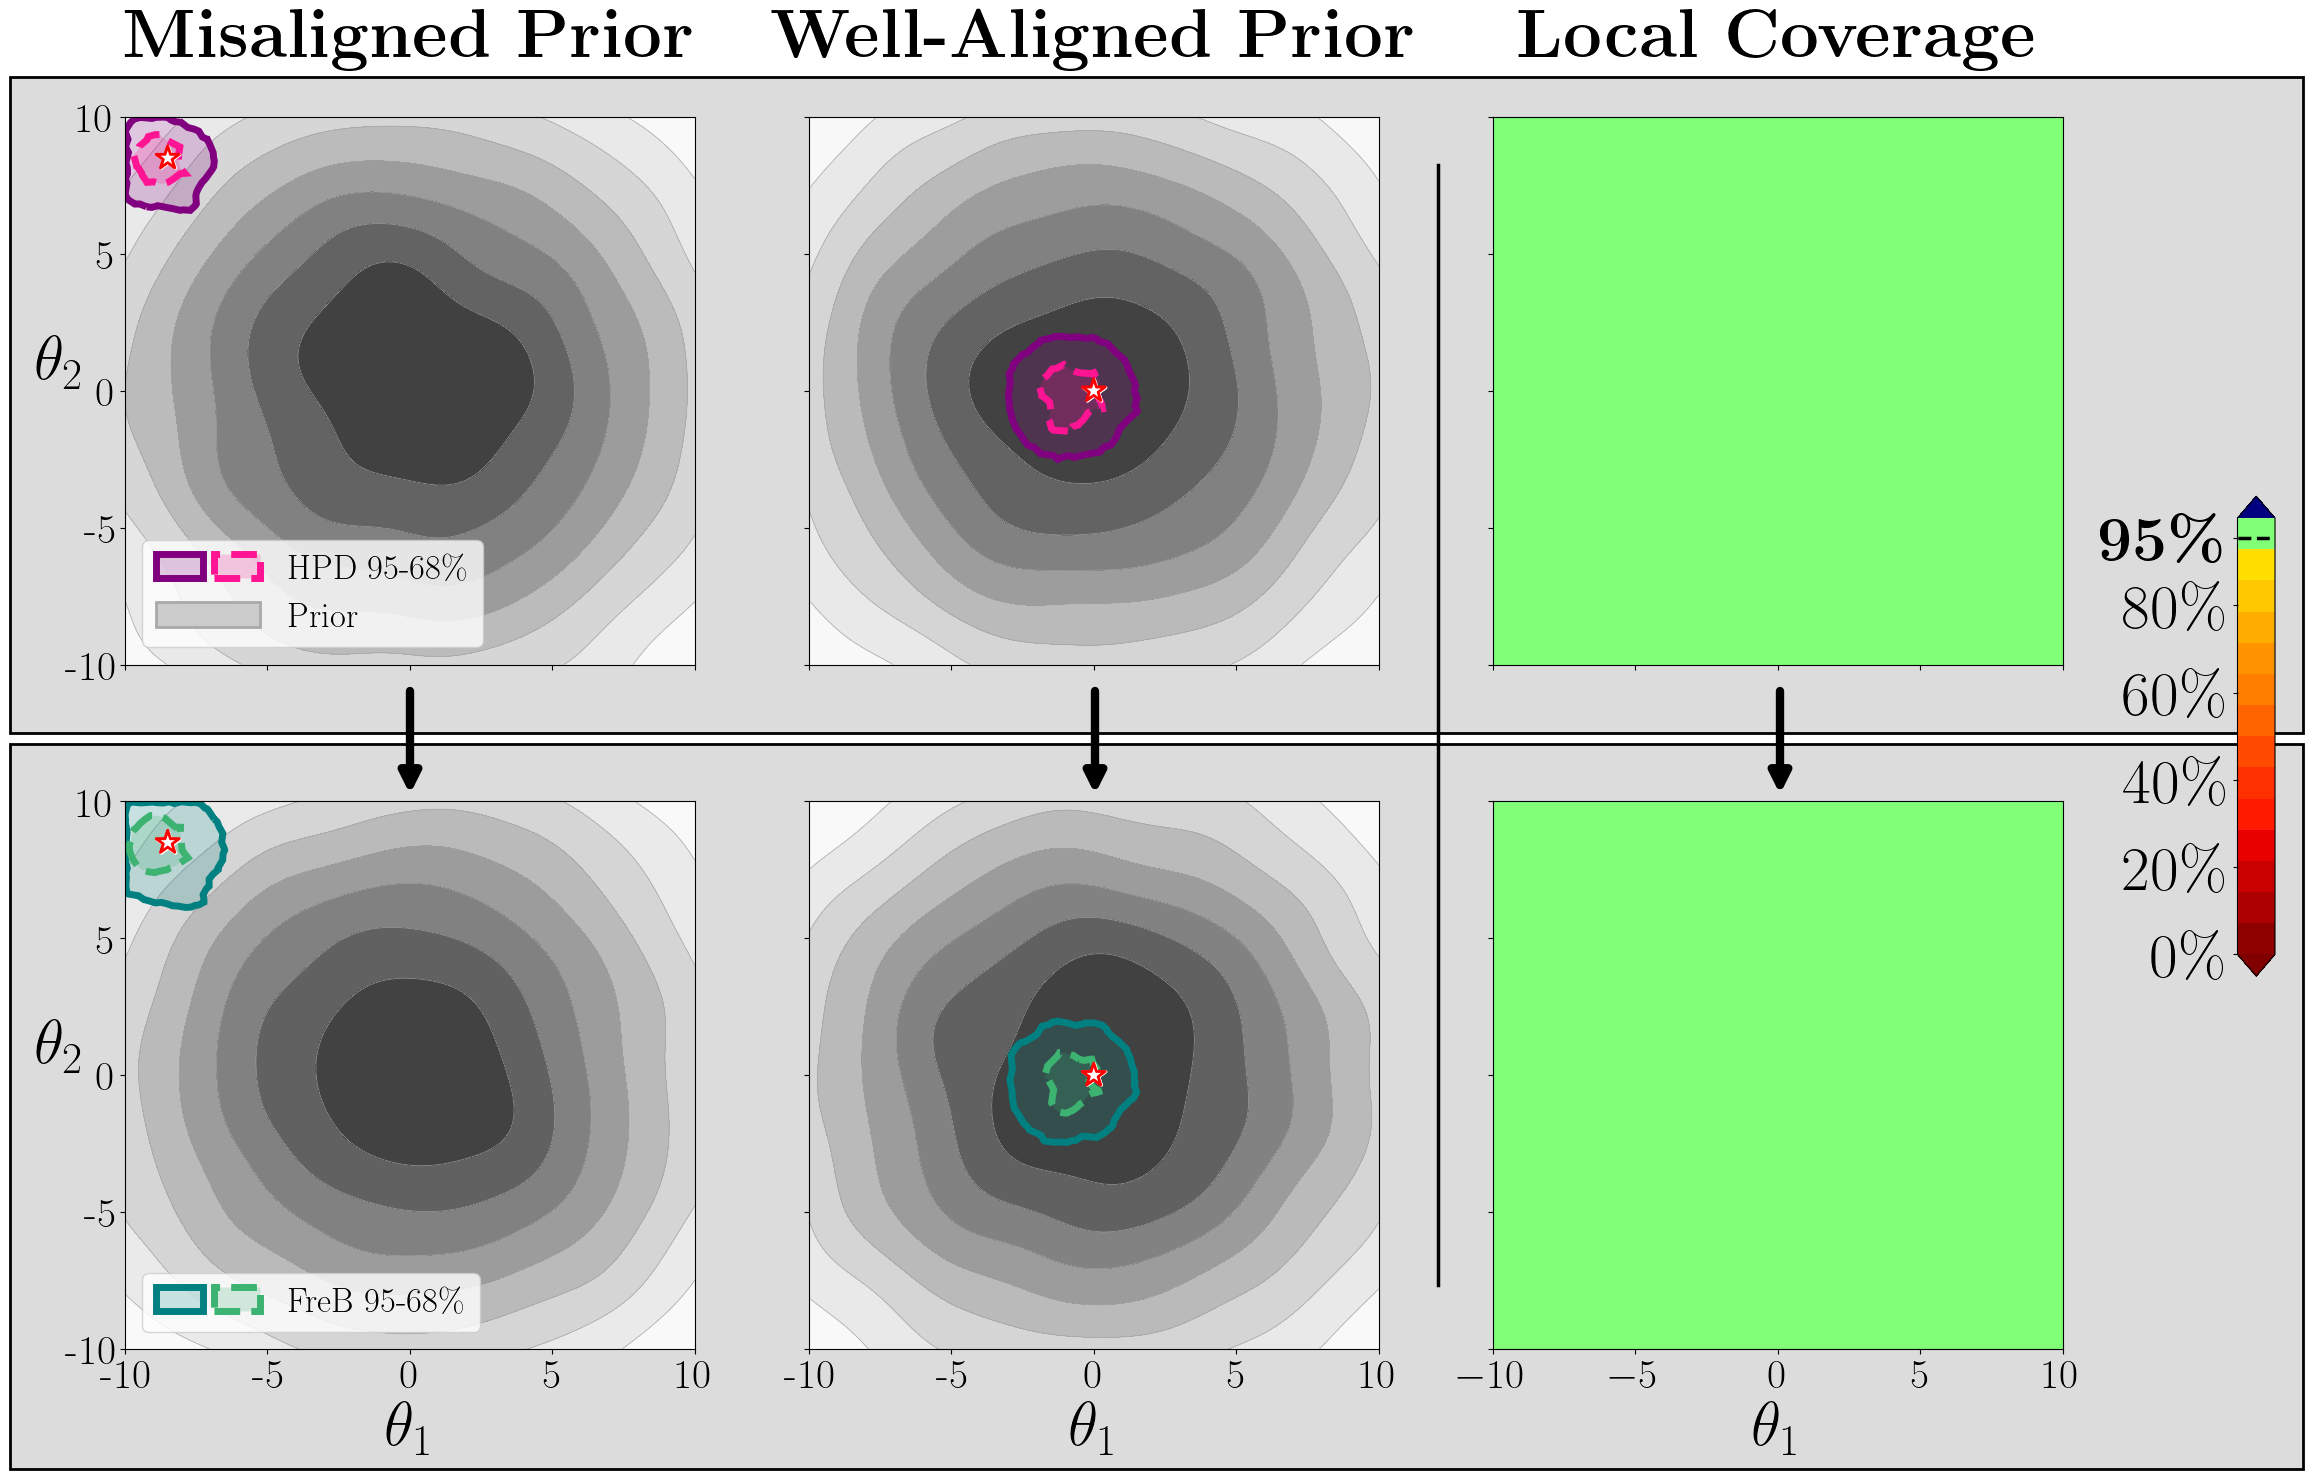

In [71]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

fig, ax = plt.subplots(2, 3, figsize=(25, 16))
fig.subplots_adjust(hspace=0.25)

plot_parameter_regions(
    *credible_sets[1],
    param_dim=2,
    true_parameter=true_theta[1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink', #'hotpink',  # credible sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=False,
    custom_ax=ax[0][0]
)
ax[0][0].set_xticklabels([])
ax[0][0].set_xlabel('')
ax[0][0].set_ylabel(r'$\theta_2$', fontsize=45)
ax[0][0].tick_params(labelsize=30)
ax[0][0].set_title(r'\textbf{Misaligned Prior}', size=50, pad=43)

plot_parameter_regions(
    *[confidence_sets[j][1] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen', #'darkseagreen', # confidence sets
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=False,
    custom_ax=ax[1][0]
)
ax[1][0].tick_params(labelsize=30)
ax[1][0].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][0].set_ylabel(r'$\theta_2$', fontsize=45)


plot_parameter_regions(
    *credible_sets[-1], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[-1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink', #'hotpink',  # credible sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=True,
    custom_ax=ax[0][1]
)
ax[0][1].set_xticklabels([])
ax[0][1].set_yticklabels([])
ax[0][1].set_xlabel('')
ax[0][1].set_ylabel('', fontsize=45)
ax[0][1].tick_params(labelsize=30)
ax[0][1].set_title(r'\textbf{Well-Aligned Prior}', size=50, pad=43)

plot_parameter_regions(
    *[confidence_sets[j][-1] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[-1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen', #'darkseagreen', # confidence sets
    ],
    region_names=[
        #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=True,
    custom_ax=ax[1][1]
)
ax[1][1].tick_params(labelsize=30)
ax[1][1].set_yticklabels([])
ax[1][1].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][1].set_ylabel('', fontsize=45)


hpd_diagn_plot = coverage_probability_plot(
    parameters=diagn_objects_cred[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects_cred[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    xlims=(-10, 10),
    ylims=(-10, 10),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    #figsize=(9, 7),
    title=None,
    show_text=False,
    custom_ax=ax[0][2],
)
ax[0][2].set_xlim(-10, 10)
ax[0][2].set_ylim(-10, 10)
ax[0][2].set_xticks(np.linspace(-10, 10, 5).astype(int))
ax[0][2].set_yticks(np.linspace(-10, 10, 5).astype(int))
ax[0][2].set_xticklabels([])
ax[0][2].set_yticklabels([])
ax[0][2].set_xlabel('')
ax[0][2].set_ylabel('', fontsize=45, rotation=0)
ax[0][2].tick_params(labelsize=30)
ax[0][2].set_title(r'\textbf{Local Coverage}', size=50, pad=43)


_ = coverage_probability_plot(
    parameters=diagn_objects[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    xlims=(-10, 10),
    ylims=(-10, 10),
    #figsize=(9, 7),
    title=None,
    show_text=False,
    custom_ax=ax[1][2],
)
ax[1][2].set_xlim(-10, 10)
ax[1][2].set_ylim(-10, 10)
ax[1][2].set_xticks(np.linspace(-10, 10, 5).astype(int))
ax[1][2].set_yticks(np.linspace(-10, 10, 5).astype(int))
ax[1][2].tick_params(labelsize=30)
ax[1][2].set_yticklabels([])
ax[1][2].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][2].set_ylabel('', rotation=0, fontsize=45)

cax = fig.add_axes([0.97, 0.343, 0.015, 0.3])  # Adjust these values to move the colorbar
cbar = fig.colorbar(hpd_diagn_plot, format='%1.2f', cax=cax)
standard_ticks = np.round(np.linspace(0, 100, num=6), 1)
all_ticks = np.unique(np.sort(np.append(standard_ticks[:-1], CONFIDENCE_LEVEL[0] * 100))) # all_ticks = standard_ticks # 
tick_labels = [f"{label:.0f}\%" for label in all_ticks]
for i, label in enumerate(all_ticks):
    if abs(label - CONFIDENCE_LEVEL[0]*100) <= 1e-6:
        tick_labels[i] = r"$\mathbf{{{label}}}$\textbf{{\%}}".format(label=int(label))
cbar.ax.yaxis.set_ticks(all_ticks)
cbar.ax.set_yticklabels(tick_labels, fontsize=45)
cbar.ax.axhline(y=CONFIDENCE_LEVEL[0]*100, xmin=0, xmax=1, color="black", linestyle="--", linewidth=2.5)
cbar.ax.yaxis.set_ticks_position('left')  # Move ticks to the left
cbar.ax.yaxis.set_label_position('left')  # Move label to the left


fig.patches.append(patches.Rectangle((0.079, 0.495), 0.917, 0.41, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))
fig.patches.append(patches.Rectangle((0.079, 0.035), 0.917, 0.453, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))

line = mlines.Line2D(
    [0.65, 0.65],   # x-coords (start, end)
    [0.15, 0.85],               # y-coords (start, end)
    transform=fig.transFigure,
    ls='-',                  # dashed
    lw=2.5,
    color='black',
    clip_on=False
)

fig.add_artist(line)

fig.add_artist(FancyArrowPatch(
    posA=(0.239, 0.523), posB=(0.239, 0.455),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
    color='black', linewidth=6, zorder=10
))
fig.add_artist(FancyArrowPatch(
    posA=(0.513, 0.523), posB=(0.513, 0.455),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
    color='black', linewidth=6, zorder=10
))
fig.add_artist(FancyArrowPatch(
    posA=(0.787, 0.523), posB=(0.787, 0.455),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
    color='black', linewidth=6, zorder=10
))

plt.savefig('./results/sbibm_example/example0_horizontal_weak_prior.pdf', bbox_inches='tight')
plt.show()